<a href="https://colab.research.google.com/github/ecrc/GMC-DL/blob/Yiping%2FCNN_Stationary_Classification/CNN_Model_Training_Upload_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="https://cemse.kaust.edu.sa/ecrc">
        <img src="https://user-images.githubusercontent.com/35196657/127348264-3e19521e-4833-4eaf-9d69-0cd60c98c06b.png" style="padding-bottom:5px;" />
      Visit ECRC at KAUST</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ecrc/GMC-DL/blob/Yiping%2FCNN_Stationary_Classification/CNN_Model_Training_Upload_Version.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ecrc/GMC-DL/blob/Yiping/CNN_Stationary_Classification/CNN_Model_Training_Upload_Version.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [169]:
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pylab as plt
import math
from pathlib import Path # Python >= 3.5, for folder creation
import random # Random seed
from tqdm import tqdm # Progress bar in for loop

# Tensorflow
import tensorflow as tf

# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
from keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
from keras.models import Sequential,Model
from keras.utils import to_categorical
from scipy.interpolate import NearestNDInterpolator

# Part 1: Data Preprocessing

In [170]:
# Input: Stationary and nonstationary generated data
#          Stationary files are located in directory_in_str_locs_stationary (locations) 
#          and directory_in_str_z_stationary (observed values)
# 
#          File names: LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ... (locations)
#                      Z_3600_sample_1.txt, Z_3600_sample_2.txt, ... (observed values)
# 
#          Format examples: 
#          LOC_3600_sample_1.txt:         Z_3600_sample_1.txt
#          0.012863,0.006928              1.264426
#          0.019715,0.003342              -0.526158
#          ...                            ...
# 
#          step_size: Step for jumping the plot. 
#                     When step_size = 10, the notebook plots preprocessed data for number 0, 10, 20, ...
# 
# Output: npz files containing preprocessed data inside save_data_string
#         plots of the preprocessed data inside save_fig_string

# Inputs

In [276]:
# Folder places and filenames
# Stationary
directory_in_str_locs_stationary = "stationary_data/"
directory_in_str_z_stationary = "stationary_data/"
locs_string_stationary = "LOC_" # LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ...
z_string_stationary = "Z_" # Z_3600_sample_1.txt, Z_3600_sample_2.txt, ...
# Nonstationary
directory_in_str_locs_nonstationary = "nonstationary_data/"
directory_in_str_z_nonstationary = "nonstationary_data/"
locs_string_nonstationary = "LOC_"
z_string_nonstationary = "Z_"

In [277]:
# Saving places
save_data_string = "Processed_Data/"
save_fig_string = "Processed_Data/Plots/"

In [278]:
# Saving names for the npz
npzfilename_stationary = "Dat_stationary_0413Pratik.npz";
npzfilename_nonstationary = "Dat_nonstationary_0413Pratik.npz";

In [279]:
# Step for jumping the plot. step_size=10: plot number 0, 10, 20, and so on. 
step_size = 1; # Step for jumping the plot. step_size=10: plot number 0, 10, 20, and so on. 

In [280]:
# Valid for both stationary and nonstationary data. 
# If the range of locations are determined manually
manual_range_locs = False
# If the range of observations are determined manually
manual_range_z = False

In [281]:
# Range of locations when manual_range_locs = True
if manual_range_locs == True:
    startx = 0
    endx = 1
    starty = 0
    endy = 1

In [282]:
# Range of observations when manual_range_z = True
if manual_range_z == True:
    m = 0
    M = 1 # The range of observations is [m, M]. 

# Statioanry data preprocessing

In [283]:
# Initialization 
directory_in_str_locs = directory_in_str_locs_stationary
directory_in_str_z = directory_in_str_z_stationary
locs_string = locs_string_stationary
z_string = z_string_stationary

In [284]:
directory_locs = os.fsencode(directory_in_str_locs)
data_folder1_locs = os.listdir(directory_locs)

In [285]:
location_file_list = []
Z_file_list = []
for path, subdirs, files in os.walk(directory_locs):
    for name in files:
        name_string = name.decode("utf-8")
        if name_string.startswith(locs_string): 
            location_file_path = os.path.join(path, name)
            location_file_path = location_file_path.decode("utf-8")
            z_file_path = location_file_path.replace(locs_string, z_string, 1)
            location_file_list.append(location_file_path)
            Z_file_list.append(z_file_path)

In [286]:
# loc_files is the file name for plotting. 
loc_files = []
for i in range(len(location_file_list)): 
    replace_res = location_file_list[i].replace(directory_in_str_locs, "")
    replace_res = replace_res.replace("\\", "_")
    loc_files.append(replace_res)

In [287]:
# Grid row and column
GRID_ROWS = 10
GRID_COLS = 10

# Initialization continued
ndata = len(location_file_list)
#ndata = 100 # Test
stationary_x_train = np.zeros((ndata,GRID_COLS,GRID_ROWS))

stationary_y_train = np.zeros(ndata) # Zero = the model is stationary. One = nonstationary. 

In [288]:
# Initialization continued
param_val_is_stat = 1;
npzfilename = npzfilename_stationary;

In [289]:
# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_is_stat.fill(param_val_is_stat)

param_list = []

In [290]:
# Main program for data preprocessing

for i_folder in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i_folder,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get location and observation files for each subsample
    loc_text = location_file_list[i_folder]
    z_text = Z_file_list[i_folder]
    # Load the location and z files
    location_file = open(loc_text)
    Z_value_file = open(z_text)
#     print(location_file)
    
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    
    ### random selection of subsample of locations
    idx = np.random.randint(len(locations), size=2500)
    locations = locations[idx,:]
    Z_values = Z_values[idx]
    
    
    #==========
    # End of data extraction
    #==========
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)

    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        output_arr = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    stationary_x_train[i_folder] = Z

100%|██████████| 10000/10000 [00:43<00:00, 231.21it/s]


In [291]:
stationary_x_train.shape

(10000, 10, 10)

In [292]:
npzfilename

'Dat_stationary_0413Pratik.npz'

In [293]:
# Save to file
nparams = np.array(param_list)
Path(save_data_string).mkdir(parents=True, exist_ok=True)
np.savez( save_data_string + npzfilename, x = stationary_x_train, y = stationary_y_train, params = nparams)

In [189]:
# Path(save_fig_string).mkdir(parents=True, exist_ok=True)
# for i in tqdm(range(0 , len(loc_files) , int(step_size))):
# #for i in tqdm(range(0, 100, int(step_size))): 
#     plt.figure()
#     ax = sns.heatmap( stationary_x_train[i] , linewidth=0)
#     plt.savefig(save_fig_string + npzfilename + loc_files[i] +".png")
#     plt.close()

<AxesSubplot:>

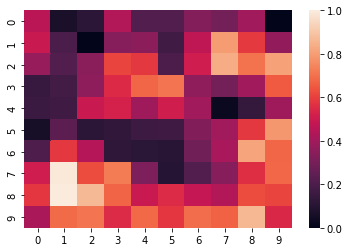

In [190]:
sns.heatmap( stationary_x_train[700] , linewidth=0)

# Nonstationary data preprocessing

In [231]:
# Initialization 
directory_in_str_locs = directory_in_str_locs_nonstationary
directory_in_str_z = directory_in_str_z_nonstationary
locs_string = locs_string_nonstationary
z_string = z_string_nonstationary

In [232]:
directory_locs = os.fsencode(directory_in_str_locs)
data_files_locs = os.listdir(directory_locs)

In [233]:
# list of filename
loc_files = [f for f in os.listdir(directory_in_str_locs_nonstationary) if f.startswith(locs_string_nonstationary)]

In [234]:
# Grid row and column
GRID_ROWS = 10
GRID_COLS = 10

# Initialization continued
ndata = len(loc_files)
#ndata = 100 # Test
nonstationary_x_train = np.zeros((ndata,GRID_COLS,GRID_ROWS))

nonstationary_y_train = np.ones(ndata) # Zero = the model is stationary. One = nonstationary. 

In [235]:
# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_val_is_stat = 0; # Nonstationary. 
param_is_stat.fill(param_val_is_stat)

param_list = []

In [236]:
# Initialization continued
npzfilename = npzfilename_nonstationary;

In [237]:
# Main program for data preprocessing
for i_folder in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i_folder,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get paired location and observation files
#     print(loc_files[i])
    loc_text = loc_files[i_folder]
    z_text = loc_text.replace(locs_string, z_string, 1)
    # Load the location and z files
    location_file = open(directory_in_str_locs + loc_text)
    Z_value_file = open(directory_in_str_z + z_text)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    
    ### random selection of subsample of locations
    idx = np.random.randint(len(locations), size=2500)
    locations = locations[idx,:]
    Z_values = Z_values[idx]
    
    
    #==========
    # End of data extraction
    #==========
    # Check if there is NaN value
    if any(np.isnan(Z_values)) == True:
        print("Warning: NaN values occur in i=", i, "; location file:", loc_text)
        Z_values[np.isnan(Z_values)] = 0
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        output_arr = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    nonstationary_x_train[i_folder] = Z

100%|██████████| 10000/10000 [00:31<00:00, 317.52it/s]


In [238]:
# nonstationary_x_train = nonstationary_x_train.reshape(504,100,50,2)

In [239]:
# Save to file
nparams = np.array(param_list)
Path(save_data_string).mkdir(parents=True, exist_ok=True)
np.savez( save_data_string + npzfilename, x = nonstationary_x_train, y = nonstationary_y_train, params = nparams)

In [240]:
# Path(save_fig_string).mkdir(parents=True, exist_ok=True)
# for i in tqdm(range(0 , len(loc_files) , int(step_size))):
# #for i in tqdm(range(0, 100, int(step_size))): 
#     plt.figure()
#     ax = sns.heatmap( nonstationary_x_train[i] , linewidth=0)
#     plt.savefig(save_fig_string + npzfilename + loc_files[i] +".png")
#     plt.close()

<AxesSubplot:>

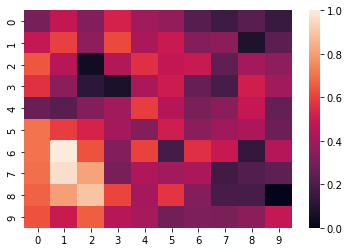

In [241]:
sns.heatmap( nonstationary_x_train[1], linewidth=0)

# Part 2: CNN Model Training

In [242]:
# Train the CNN model that can determine whether a spatial data is stationary. 
# Input: 
#    Preprocessed data in npz format: stationary_npz_filename (stationary) and nonstationary_npz_filename (nonstationary). 
# 
#    Location for saving the CNN model: model_saving_location. 
# 
#    Split rate: split_size_stationary (stationary) and split_size_nonstationary (nonstationary). 
#                The training data will be split following the split size. 
#                For instance, when split_size_stationary = 0.8, 
#                then 80% stationary data is the training data, and the rest 20% are the test data. 
# 
# Output: 
#    Trained CNN model saved in model_saving_location. 
#    Histogram and outlines for the correct rate of the CNN training model. 

# Inputs

In [318]:
# Filename for preprocessing data (.npz format)
save_data_string = "Spatial_Classifier-DL/Processed_Data/"
stationary_npz_filename = save_data_string + npzfilename_stationary
nonstationary_npz_filename = save_data_string + npzfilename_nonstationary

In [319]:
# Places for location saving
model_saving_location = 'Model_Example'

In [320]:
# Split rate for stationary data
split_size_stationary = 0.9
# Split rate for nonstationary data
split_size_nonstationary = 0.9

# Loading Data

In [321]:
# Stationary data - load npz file
npzfile = np.load(stationary_npz_filename, allow_pickle=True)
stationary_x_all = npzfile['x'] # Preprocessed data
stationary_y_all = npzfile['y'] # Stationary or nonstationary
stationary_params = npzfile['params']
print(stationary_x_all.shape)

(10000, 10, 10)


In [323]:
# Nonstationary data - load npz file
npzfile = np.load(nonstationary_npz_filename, allow_pickle=True)
tx = npzfile['x']
nonstationary_x_all = npzfile['x'] # Preprocessed data
nonstationary_y_all = npzfile['y'] # Stationary or nonstationary
nonstationary_params = npzfile['params']
print(nonstationary_x_all.shape)

(10000, 10, 10)


# Randomising and Splitting Data

In [299]:
# Split for stationary data
total_size_stationary = int(len(stationary_x_all))
training_size_stationary = int(total_size_stationary * split_size_stationary)
test_size_stationary = total_size_stationary - training_size_stationary
print(training_size_stationary)
print(test_size_stationary)

# Split for nonstationary data
total_size_nonstationary = int(len(nonstationary_x_all))
training_size_nonstationary = int(total_size_nonstationary * split_size_nonstationary)
test_size_nonstationary = total_size_nonstationary - training_size_nonstationary
print(training_size_nonstationary)
print(test_size_nonstationary)

9000
1000
9000
1000


In [300]:
# Shuffler for stationary and nonstationary
random.seed(220)
shuffler_stationary = random.sample(range(total_size_stationary), total_size_stationary)
shuffler_nonstationary = random.sample(range(total_size_nonstationary), total_size_nonstationary)

In [301]:
# Grid row and column
GRID_ROWS = 10
GRID_COLS = 10
# Shuffle data
stationary_x_shuffled = stationary_x_all[shuffler_stationary, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_shuffled = stationary_y_all[shuffler_stationary]
stationary_params_shuffled = stationary_params[shuffler_stationary, ]
nonstationary_x_shuffled = nonstationary_x_all[shuffler_nonstationary, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_shuffled = nonstationary_y_all[shuffler_nonstationary]
nonstationary_params_shuffled = nonstationary_params[shuffler_nonstationary, ]

In [302]:
# Training data
stationary_x_train = stationary_x_shuffled[0:training_size_stationary, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_train = stationary_y_shuffled[0:training_size_stationary]
stationary_params_train = stationary_params_shuffled[0:training_size_stationary, ]
nonstationary_x_train = nonstationary_x_shuffled[0:training_size_nonstationary, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_train = nonstationary_y_shuffled[0:training_size_nonstationary]
nonstationary_params_train = nonstationary_params_shuffled[0:training_size_nonstationary, ]
# Test data
stationary_x_test = stationary_x_shuffled[training_size_stationary:, 0:GRID_ROWS, 0:GRID_COLS]
stationary_y_test = stationary_y_shuffled[training_size_stationary:]
stationary_params_test = stationary_params_shuffled[training_size_stationary:, ]
nonstationary_x_test = nonstationary_x_shuffled[training_size_nonstationary:, 0:GRID_ROWS, 0:GRID_COLS]
nonstationary_y_test = nonstationary_y_shuffled[training_size_nonstationary:]
nonstationary_params_test = nonstationary_params_shuffled[training_size_nonstationary:, ]
# Combine
x_train = np.concatenate((stationary_x_train,nonstationary_x_train))
y_train = np.concatenate((stationary_y_train,nonstationary_y_train))
params_train = np.concatenate((stationary_params_train,nonstationary_params_train))
x_test = np.concatenate((stationary_x_test,nonstationary_x_test))
y_test = np.concatenate((stationary_y_test,nonstationary_y_test))
params_test = np.concatenate((stationary_params_test,nonstationary_params_test))

In [303]:
# Add a channels dimension
# x_train = x_train[..., tf.newaxis].astype("float32")
# x_test = x_test[..., tf.newaxis].astype("float32")

### Check the x_train and x_test shapes before reshaping
x_train = x_train.reshape(x_train.shape[0], 10, 10, 1)
x_test = x_test.reshape(x_test.shape[0], 10, 10, 1)

In [304]:
print(x_train.shape)
print(x_test.shape)

(18000, 10, 10, 1)
(2000, 10, 10, 1)


In [305]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Start training model

In [306]:
training_size = x_train.shape[0]
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(training_size).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [307]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


# Model

In [308]:
#create model

model = Sequential()
#add model layers
# model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(100, 100, 1)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Conv2D(64, kernel_size=5, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [309]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [310]:
#train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size = 256, verbose = 2)

Train on 18000 samples, validate on 2000 samples
Epoch 1/15
 - 2s - loss: 0.6937 - accuracy: 0.4913 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
 - 2s - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
 - 2s - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
 - 2s - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/15
 - 2s - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 6/15
 - 2s - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/15
 - 2s - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/15
 - 2s - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 9/15


KeyboardInterrupt: 

In [94]:
# class MyModel(Model):
#   def __init__(self):
#     super(MyModel, self).__init__()
#     self.conv1 = Conv2D(32, 3, activation='relu')
#     self.flatten = Flatten()
#     self.d1 = Dense(128, activation='relu')
#     self.d2 = Dense(2, )

#   def call(self, x):
#     x = self.conv1(x)
#     x = self.flatten(x)
#     x = self.d1(x)
#     return self.d2(x)

# # Create an instance of the model
# model = MyModel()

# # Categorical Cross entropy loss to for classification
# loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # Adaptive Learning rate
# optimizer = tf.keras.optimizers.Adam()

# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# # Gradient Descent
# @tf.function
# def train_step(images, labels):
#   with tf.GradientTape() as tape:
#     # training=True is only needed when a more complex architecture
#     # is implemented
#     predictions = model(images)
#     loss = loss_object(labels, predictions)
#   gradients = tape.gradient(loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#   train_loss(loss)
#   train_accuracy(labels, predictions)

# @tf.function
# def test_step(images, labels):
#   # training=False is only needed if there are layers with different
#   # behavior during training versus inference (e.g. Dropout).
#   predictions = model(images)
#   t_loss = loss_object(labels, predictions)

#   test_loss(t_loss)
#   test_accuracy(labels, predictions)

# # test_ds

# EPOCHS = 25 # Original: epochs = 25. 

# #training_seed = 1001 # Suhas training
# #random.seed(training_seed)
# #tf.random.set_seed(training_seed) # Random seed doesn't work? 
# for epoch in range(EPOCHS):
#     print(epoch)
#   # Reset the metrics at the start of the next epoch
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()
#     print(epoch)
#     count = 0
#     for images, labels in train_ds:
#         train_step(images, labels)
#         count += 1
#         print(count)

#     for test_images, test_labels in test_ds:
#         test_step(test_images, test_labels)

#     print(
#          f'Epoch {epoch + 1}, '
#          f'Loss: {train_loss.result()}, '
#          f'Accuracy: {train_accuracy.result() * 100}, '
#          f'Test Loss: {test_loss.result()}, '
#          f'Test Accuracy: {test_accuracy.result() * 100}'
#          )

In [218]:
# Summary of the model

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          51264     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 183,042
Trainable params: 183,042
Non-trainable params: 0
_________________________________________________________________


In [96]:
# model.save("my_model")

In [65]:
# model.save(model_saving_location, save_format='tf')

In [64]:
# model_saving_location

# Model testing

In [340]:
# Folder places and filenames
# Stationary
directory_in_str_locs_stationary = "stationary_test/"
directory_in_str_z_stationary = "stationary_test/"
locs_string_stationary = "LOC_" # LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ...
z_string_stationary = "Z_" # Z_3600_sample_1.txt, Z_3600_sample_2.txt, ...



# Initialization 
directory_in_str_locs = directory_in_str_locs_stationary
directory_in_str_z = directory_in_str_z_stationary
locs_string = locs_string_stationary
z_string = z_string_stationary

directory_locs = os.fsencode(directory_in_str_locs)
data_folder1_locs = os.listdir(directory_locs)

location_file_list = []
Z_file_list = []
for path, subdirs, files in os.walk(directory_locs):
    for name in files:
        name_string = name.decode("utf-8")
        if name_string.startswith(locs_string): 
            location_file_path = os.path.join(path, name)
            location_file_path = location_file_path.decode("utf-8")
            z_file_path = location_file_path.replace(locs_string, z_string, 1)
            location_file_list.append(location_file_path)
            Z_file_list.append(z_file_path)

# loc_files is the file name for plotting. 
loc_files = []
for i in range(len(location_file_list)): 
    replace_res = location_file_list[i].replace(directory_in_str_locs, "")
    replace_res = replace_res.replace("\\", "_")
    loc_files.append(replace_res)

# Grid row and column
GRID_ROWS = 10
GRID_COLS = 10

# Initialization continued
ndata = len(location_file_list)
#ndata = 100 # Test
stationary_x_test = np.zeros((ndata,GRID_COLS,GRID_ROWS))

stationary_y_test = np.zeros(ndata) # Zero = the model is stationary. One = nonstationary. 

# Initialization continued
param_val_is_stat = 1;
npzfilename = npzfilename_stationary;

# Initialization continued
npzfilename = npzfilename_nonstationary;

# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_is_stat.fill(param_val_is_stat)

param_list = []

# Main program for data preprocessing
for i_folder in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i_folder,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get location and observation files for each subsample
    loc_text = location_file_list[i_folder]
    z_text = Z_file_list[i_folder]
    # Load the location and z files
    location_file = open(loc_text)
    Z_value_file = open(z_text)
#     print(location_file)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    
    ### random selection of subsample of locations
    idx = np.random.randint(len(locations), size=2500)
    locations = locations[idx,:]
    Z_values = Z_values[idx]
    
    
    #==========
    # End of data extraction
    #==========
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        output_arr = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    stationary_x_test[i_folder] = Z

100%|██████████| 100/100 [00:00<00:00, 254.63it/s]


In [342]:
stationary_x_test.shape

(100, 10, 10)

<AxesSubplot:>

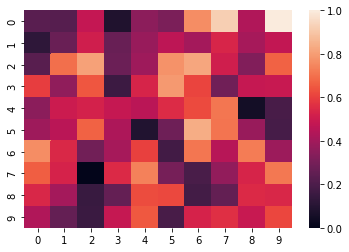

In [343]:
sns.heatmap( stationary_x_test[9] , linewidth=0)

In [344]:
stationary_x_test = stationary_x_test.reshape(100,10,10,1)

In [347]:
count = 0

for i in range(100):
    if prediction[i,0] >= 0.5:
        count += 1
print(count/100)

0.0


In [270]:
# Folder places and filenames
# non-Stationary
directory_in_str_locs_stationary = "nonstationary_test/"
directory_in_str_z_stationary = "nonstationary_test/"
locs_string_stationary = "LOC_" # LOC_3600_sample_1.txt, LOC_3600_sample_2.txt, ...
z_string_stationary = "Z_" # Z_3600_sample_1.txt, Z_3600_sample_2.txt, ...



# Initialization 
directory_in_str_locs = directory_in_str_locs_stationary
directory_in_str_z = directory_in_str_z_stationary
locs_string = locs_string_stationary
z_string = z_string_stationary

directory_locs = os.fsencode(directory_in_str_locs)
data_folder1_locs = os.listdir(directory_locs)

location_file_list = []
Z_file_list = []
for path, subdirs, files in os.walk(directory_locs):
    for name in files:
        name_string = name.decode("utf-8")
        if name_string.startswith(locs_string): 
            location_file_path = os.path.join(path, name)
            location_file_path = location_file_path.decode("utf-8")
            z_file_path = location_file_path.replace(locs_string, z_string, 1)
            location_file_list.append(location_file_path)
            Z_file_list.append(z_file_path)

# loc_files is the file name for plotting. 
loc_files = []
for i in range(len(location_file_list)): 
    replace_res = location_file_list[i].replace(directory_in_str_locs, "")
    replace_res = replace_res.replace("\\", "_")
    loc_files.append(replace_res)

# Grid row and column
GRID_ROWS = 10
GRID_COLS = 10

# Initialization continued
ndata = len(location_file_list)
#ndata = 100 # Test
nonstationary_x_test = np.zeros((ndata,GRID_COLS,GRID_ROWS))

nonstationary_y_test = np.ones(ndata) # Zero = the model is stationary. One = nonstationary. 

# Initialization continued
param_val_is_stat = 1;
npzfilename = npzfilename_stationary;

# Initialization continued
npzfilename = npzfilename_nonstationary;

# Initialization continued
param_is_stat = np.ones(ndata)
#param_samplenum.fill(param_val_samplenum)
param_is_stat.fill(param_val_is_stat)

param_list = []

# Main program for data preprocessing
for i_folder in tqdm(range(ndata)):
    # Append the parameter to samples. 
    param_dict = {
        "sample": i_folder,
        "is_stat": param_val_is_stat
    }
    param_list.append(param_dict)
    #==========
    # Data extraction
    #===========
    # Get location and observation files for each subsample
    loc_text = location_file_list[i_folder]
    z_text = Z_file_list[i_folder]
    # Load the location and z files
    location_file = open(loc_text)
    Z_value_file = open(z_text)
#     print(location_file)
    locations = np.loadtxt(location_file, delimiter=',')
    Z_values = np.loadtxt(Z_value_file, delimiter=',')
    
    ### random selection of subsample of locations
    idx = np.random.randint(len(locations), size=2500)
    locations = locations[idx,:]
    Z_values = Z_values[idx]
    
    
    #==========
    # End of data extraction
    #==========
    # Compute the output grid
    output_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_sum_arr = np.zeros((GRID_ROWS,GRID_COLS))
    grid_div_arr = np.zeros((GRID_ROWS,GRID_COLS))
    if manual_range_locs == False:
        # Start and end locations (Auto)
#         print(locations[:,0],locations[:,1])
        startx = min(locations[:, 0])
        starty = min(locations[:, 1])
        endx = max(locations[:, 0])
        endy = max(locations[:, 1])
#     print(locations)
    locations[:,0] = (locations[:, 0] - startx)/(endx - startx)
    locations[:,1] = (locations[:, 1] - starty)/(endy - starty)
#     print(locations)
    
    X = np.linspace(0, 1,GRID_COLS)
    Y = np.linspace(0, 1,GRID_ROWS)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    interp = NearestNDInterpolator(locations, Z_values)
    Z = interp(X, Y)
#     break
#     # Get the summation and division
#     for j in range(locations.shape[0]):
#         # Get the grid locations (x, y). Result: [y][x], because x is column (x=0 is the first column). 
#         x = int(math.floor((locations[j][0] - startx) * GRID_COLS / (endx - startx)))
#         y = int(math.floor((locations[j][1] - starty) * GRID_ROWS / (endy - starty)))
#         # For boundary value problems
#         x = min(x, GRID_COLS - 1)
#         y = min(y, GRID_ROWS - 1)
#         val = Z_values[j]
#         # Add the summation and division
#         grid_sum_arr[y][x] = grid_sum_arr[y][x] + val
#         grid_div_arr[y][x] += 1
#     # Generate output
#     for j1 in range(GRID_ROWS):
#         for j2 in range(GRID_COLS):
#             if grid_div_arr[j1][j2] > 0:
#                 # Mean value in a cell
#                 output_arr[j1][j2] += (grid_sum_arr[j1][j2] / grid_div_arr[j1][j2])
#             else:
#                 # Mean value over all regions if the cell has no locations
#                 output_arr[j1][j2] += np.mean(Z_values)
    if manual_range_z == False:
        # Normalize (Auto)
        m = np.min(Z)
        M = np.max(Z)
    if m == M:
        output_arr = np.ones((GRID_ROWS,GRID_COLS)) * 0.5 # All 0.5
    else: 
        # Range from 0 to 1. 
        Z = (Z - m) / (M - m)
    # Save results
    nonstationary_x_test[i_folder] = Z

100%|██████████| 100/100 [00:00<00:00, 298.48it/s]


In [271]:
nonstationary_x_test.shape

(100, 10, 10)

<AxesSubplot:>

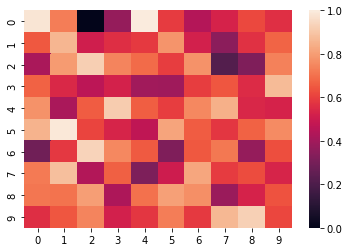

In [272]:
sns.heatmap(nonstationary_x_test[1] , linewidth=0)

In [273]:
nonstationary_x_test = nonstationary_x_test.reshape(100,10,10,1)

In [274]:
prediction = model.predict(nonstationary_x_test)
count = 0

for i in range(100):
    if prediction[i,1] >= 0.5:
        count += 1
print(count/100)

0.71


In [230]:
prediction

array([[1.97439545e-06, 9.99997973e-01],
       [1.92589544e-09, 1.00000000e+00],
       [9.22028303e-01, 7.79716522e-02],
       [9.46380105e-03, 9.90536153e-01],
       [9.23621774e-01, 7.63782784e-02],
       [9.84904408e-01, 1.50955664e-02],
       [9.99792874e-01, 2.07096658e-04],
       [9.99996543e-01, 3.40643760e-06],
       [6.67535126e-01, 3.32464874e-01],
       [4.87802890e-06, 9.99995112e-01],
       [5.17427223e-04, 9.99482512e-01],
       [1.00000000e+00, 3.52984841e-08],
       [1.42592518e-03, 9.98574018e-01],
       [1.00000000e+00, 1.47778956e-10],
       [9.98455524e-01, 1.54444831e-03],
       [9.94086504e-01, 5.91350719e-03],
       [9.99999881e-01, 1.01037990e-07],
       [1.69063024e-02, 9.83093739e-01],
       [6.33233666e-01, 3.66766244e-01],
       [5.93294136e-10, 1.00000000e+00],
       [1.00000000e+00, 6.36375397e-11],
       [1.15258561e-03, 9.98847365e-01],
       [1.00000000e+00, 1.28686413e-08],
       [2.59810150e-01, 7.40189850e-01],
       [9.997416

In [72]:
probnonstat_stationary = probnonstat_all[np.where(testing_y==0)]
probnonstat_nonstationary = probnonstat_all[np.where(testing_y==1)]

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

# Histogram of the stationarity index 

(array([  2.,   1.,   2.,   1.,   0.,   2.,   3.,   1.,   6., 320.]),
 array([0.02274253, 0.12046828, 0.21819402, 0.3159198 , 0.4136455 ,
        0.51137125, 0.609097  , 0.70682275, 0.8045485 , 0.90227425,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

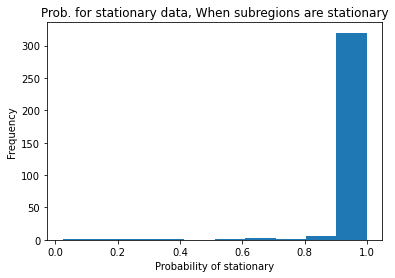

In [94]:
# Histogram of stationarity index (probability that the data is stationary), for stationary testing data. 
plt.title("Prob. for stationary data, When subregions are stationary")
plt.xlabel("Probability of stationary")
plt.ylabel("Frequency")
plt.hist(prediction[:,0])

(array([143.,   4.,   1.,   2.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([0.        , 0.00283023, 0.00566046, 0.00849069, 0.01132092,
        0.01415116, 0.01698139, 0.01981162, 0.02264185, 0.02547208,
        0.02830231], dtype=float32),
 <BarContainer object of 10 artists>)

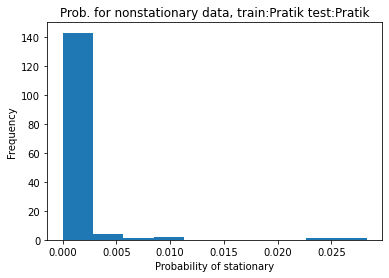

In [ ]:
# Histogram of stationarity index (probability that the data is stationary), for nonstatoinary testing data. 
plt.title("Prob. for nonstationary data, train:" + training_label + " test:" + test_label)
plt.xlabel("Probability of stationary")
plt.ylabel("Frequency")
plt.hist(1-probnonstat_nonstationary)

# Outline of classification results for test data

In [ ]:
# Result of correct determination
prediction_labels = tf.argmax(prediction , 1).numpy()

In [ ]:
conf_matrix = tf.math.confusion_matrix(tf.convert_to_tensor(testing_y) , tf.convert_to_tensor(prediction_labels))
#print(conf_matrix_pratik)

# Identifying the type of error (Type I or Type II) 

true_negatives = conf_matrix[0][0].numpy()
true_positives = conf_matrix[1][1].numpy()
false_negatives = conf_matrix[1][0].numpy()
false_positives = conf_matrix[0][1].numpy()

tf.print("TN = " , true_negatives) # Negative = stationary
tf.print("TP = " , true_positives) # Positive = nonstationary
tf.print("FN = " , false_negatives)
tf.print("FP = " , false_positives)

TN =  601
TP =  152
FN =  0
FP =  4


In [ ]:
correct_stationary = true_negatives / (true_negatives + false_positives)
correct_nonstationary = true_positives / (true_positives + false_negatives)
print("Number of stationary testing samples: ", true_negatives + false_positives, "; of which correct identifications:", true_negatives)
print("Correct stationary = ", correct_stationary)
print("Number of nonstationary testing samples: ", true_positives + false_negatives, "; of which correct identifications:", true_positives)
print("Correct nonstationary = ", correct_nonstationary)

Number of stationary testing samples:  605 ; of which correct identifications: 601
Correct stationary =  0.9933884297520661
Number of nonstationary testing samples:  152 ; of which correct identifications: 152
Correct nonstationary =  1.0
